# Analysis

In [92]:
%load_ext autoreload
% autoreload 2
from dnn import pipeline
from dnn.analysis import img_scatter
import os
import tensorflow as tf
from tensorflow.contrib.data import shuffle_and_repeat, batch_and_drop_remainder
from matplotlib import pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Data

In [93]:
img_width = 64
batch_size = 32
use_hdf_data = False

In [94]:
(y == 0).sum() / y.size

0.4483540852864583

In [95]:
def has_data(null_value, threshold):
    def fn(x):
        nulls = tf.equal(x, null_value)
        null_freq = tf.reduce_mean(tf.cast(nulls, tf.float32))
        return null_freq < threshold
    return fn

### TIF Data

In [96]:
tiff_files = ["data/tif/2017-01-01_MOD09GA_background_removal_zero_inputated_image_with_cf_50perc_grid_size10-0000017664-0000000000.tif"]
n_bands = 7
tif_fields = ["b%d"%(i+1) for i in range(n_bands)]
tif_dataset = (
    tf.data.Dataset.from_generator(
        pipeline.read_tiff_gen(tiff_files, img_width),
        tf.int16,
        (img_width, img_width, n_bands)
    )
    .apply(tf.contrib.data.shuffle_and_repeat(100))
    .apply(batch_and_drop_remainder(batch_size))
)

### HDF data

In [97]:
meta_json = "ex.json"
hdf_fields = ['Cloud_Optical_Thickness', "Cloud_Water_Path", "Cirrus_Reflectance"]
data_files = ["ex.tfrecord"]

chans, parser = pipeline.hdf_tfr_fn(hdf_fields, meta_json)
hdf_dataset = (
    tf.data.Dataset.from_tensor_slices(data_files)
    .apply(shuffle_and_repeat(100))
    .flat_map(tf.data.TFRecordDataset)
    .map(parser)
    .interleave(pipeline.patchify_fn(img_width, img_width, chans), cycle_length=4)
    .map(lambda x: tf.clip_by_value(x, 0, 15000))
    .shuffle(10000)
    .apply(batch_and_drop_remainder(batch_size))
)

### Load

In [98]:
if use_hdf_data:
    dataset = hdf_dataset
    fields = hdf_fields
else:
    dataset = tif_dataset
    fields = tif_fields

x = dataset.make_one_shot_iterator().get_next()
with tf.Session() as sess:
    y = sess.run(x)

### Plot

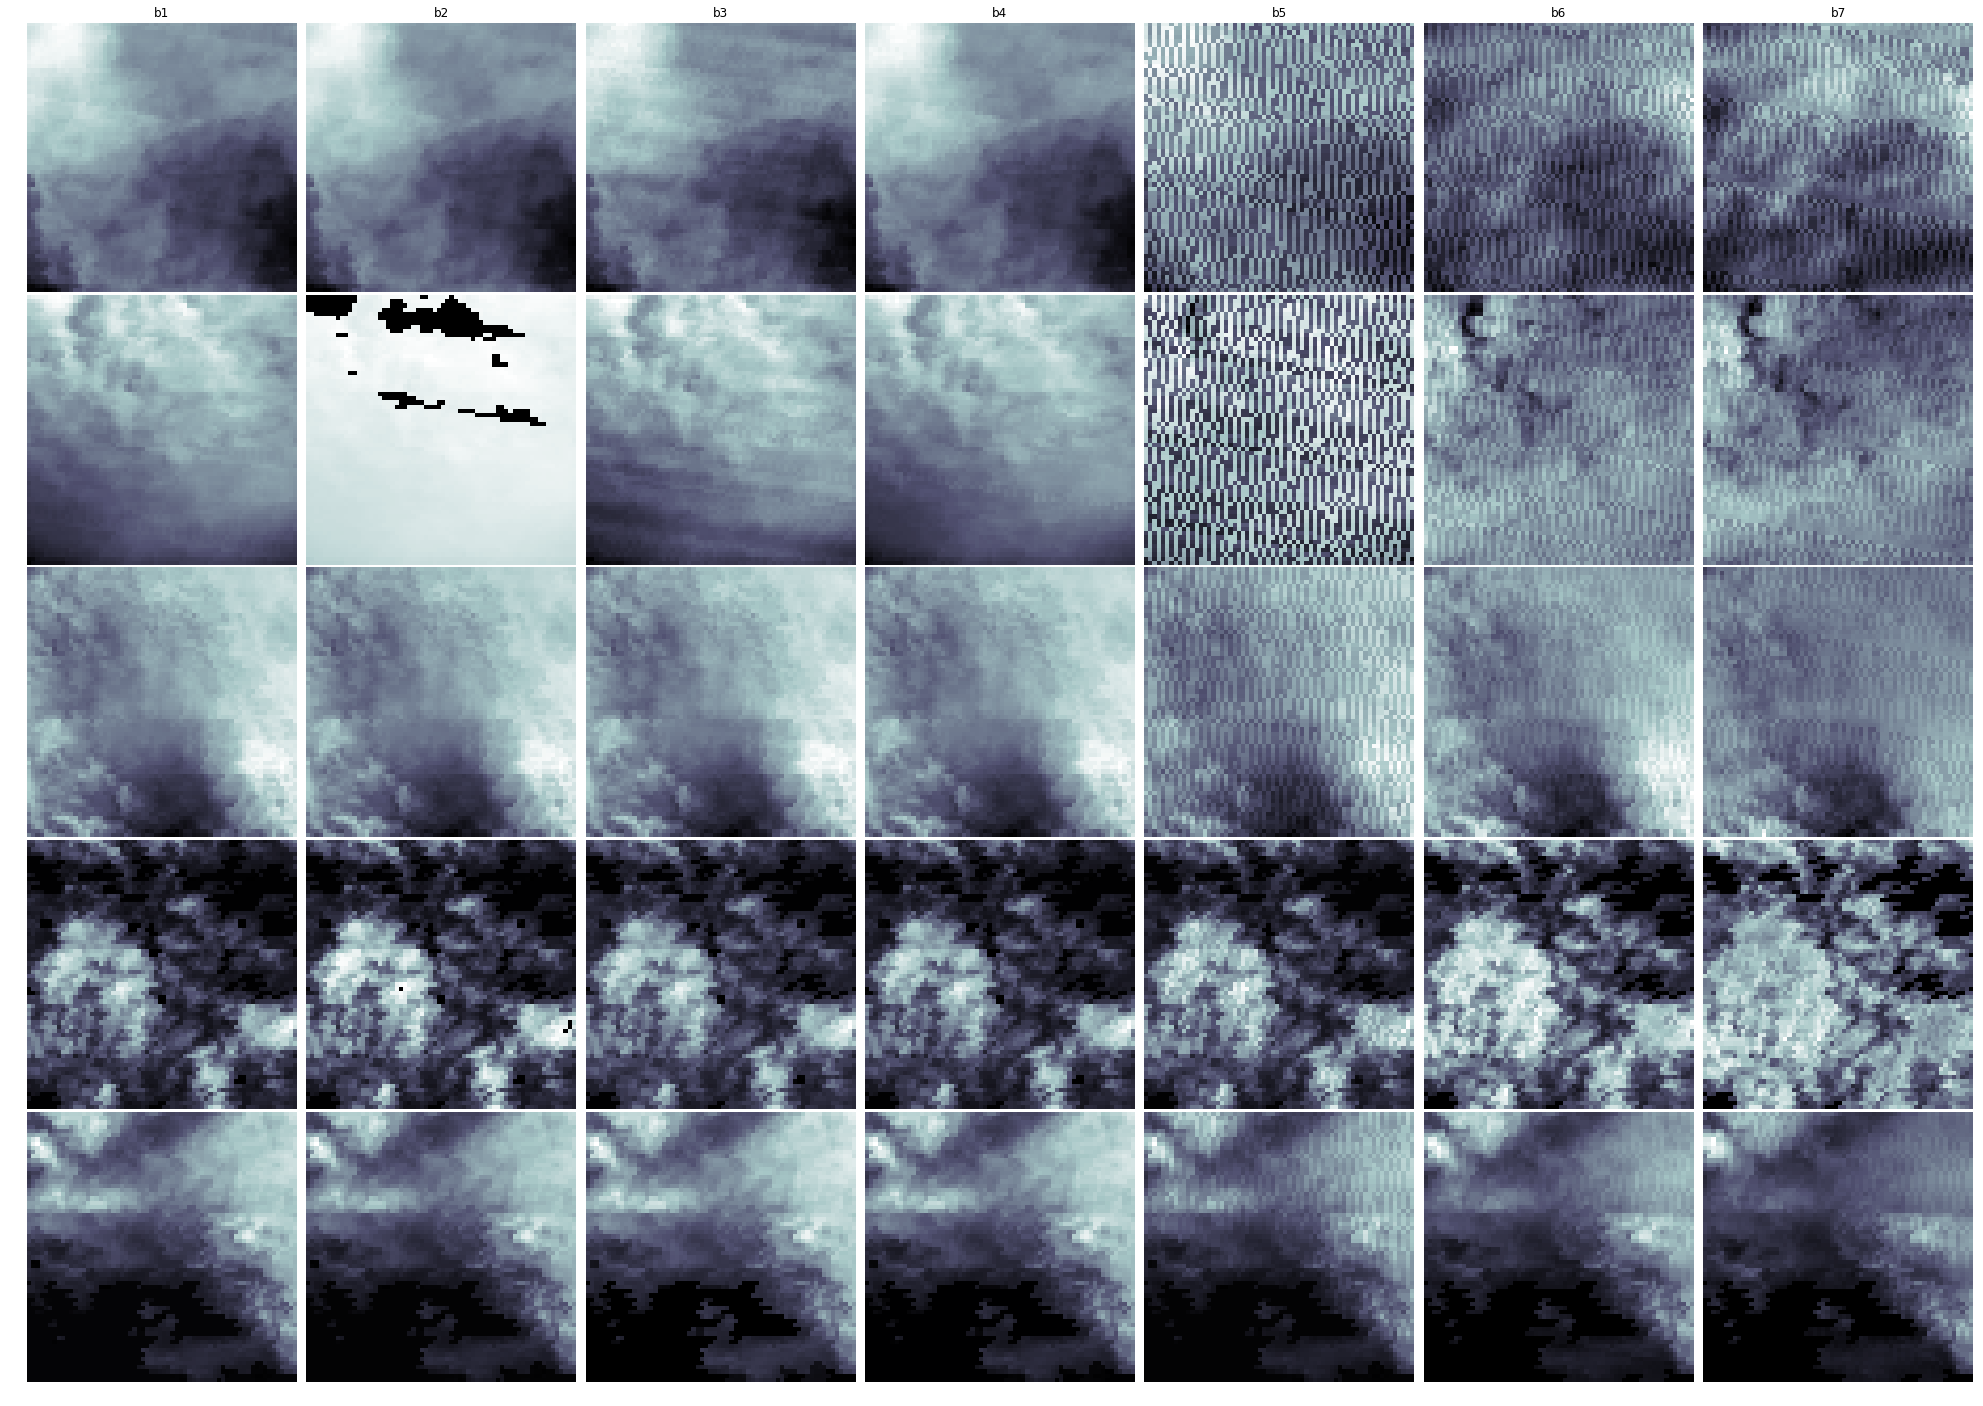

In [99]:
samples = 5
width = 5
fig, ax = plt.subplots(nrows=samples, ncols=len(fields), figsize=(len(fields) * width, samples * width))
plt.subplots_adjust(wspace=0.01, hspace=0.01)
for r in range(samples):
    for c, field in enumerate(fields):
        a = ax[r, c]
        a.imshow(y[r,:,:,c], cmap="bone")
        a.set_axis_off()
        if r == 0:
            a.set_title(field)

### Plot histogram of channel distribution

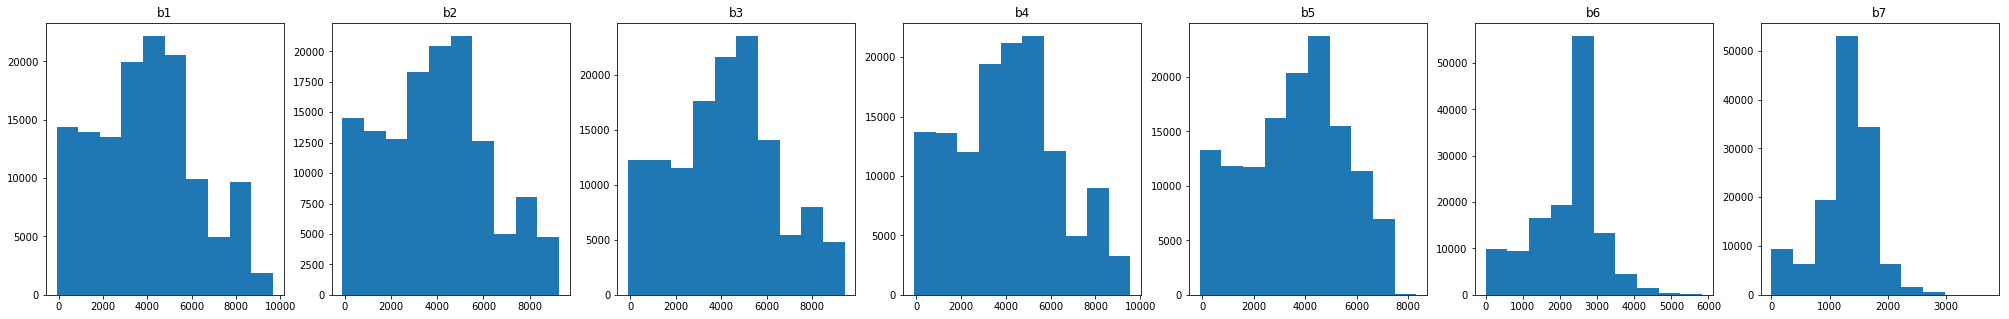

In [100]:
fig, ax = plt.subplots(ncols=len(fields), figsize=(len(fields) * 5, 5))

for i, f in enumerate(fields):
    a = ax[i]
    a.hist(y[:,:,:,i].flatten())
    a.set_title(f)


## Load Model

In [46]:
model_dir = "dnn/out/m9/"

In [25]:
!head -n 20 dnn/out/m9/run-m9.sbatch_4294967294.out

Tensorflow version: 1.9.0
Current Git Commit: b'fb66c8f'
Flags:
	data:                      ['/project/foster/clouds/geotfr/1_of_8.tfrecords', '/project/foster/clouds/geotfr/2_of_8.tfrecords', '/project/foster/clouds/geotfr/3_of_8.tfrecords', '/project/foster/clouds/geotfr/4_of_8.tfrecords', '/project/foster/clouds/geotfr/5_of_8.tfrecords', '/project/foster/clouds/geotfr/6_of_8.tfrecords', '/project/foster/clouds/geotfr/7_of_8.tfrecords', '/project/foster/clouds/geotfr/8_of_8.tfrecords']
	batch_size:                32
	model_dir:                 out/m9/
	optimizer:                 adam
	steps_per_epoch:           1000
	epochs:                    500
	new_model:                 
	shape:                     (64, 64, 7)
	discriminator:             
	lambda_disc:               0.01
	lambda_gradient_penalty:   10
	n_critic:                  5
	perceptual:                None


Starting epoch 0
Starting epoch 1


In [47]:
with open(model_dir + "ae.json", "r") as f:
    ae = tf.keras.models.model_from_json(f.read())
ae.load_weights(model_dir + "ae.h5")

In [48]:
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_input (InputLayer)        (None, 64, 64, 7)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         147584    
__________

In [49]:
[enc, dec] = ae.predict(y.astype(np.float32))

### Autoencoder output
Each column is a field (labeled), each row triplet of rows is a sample. The triplets are original, difference, and autoencoded

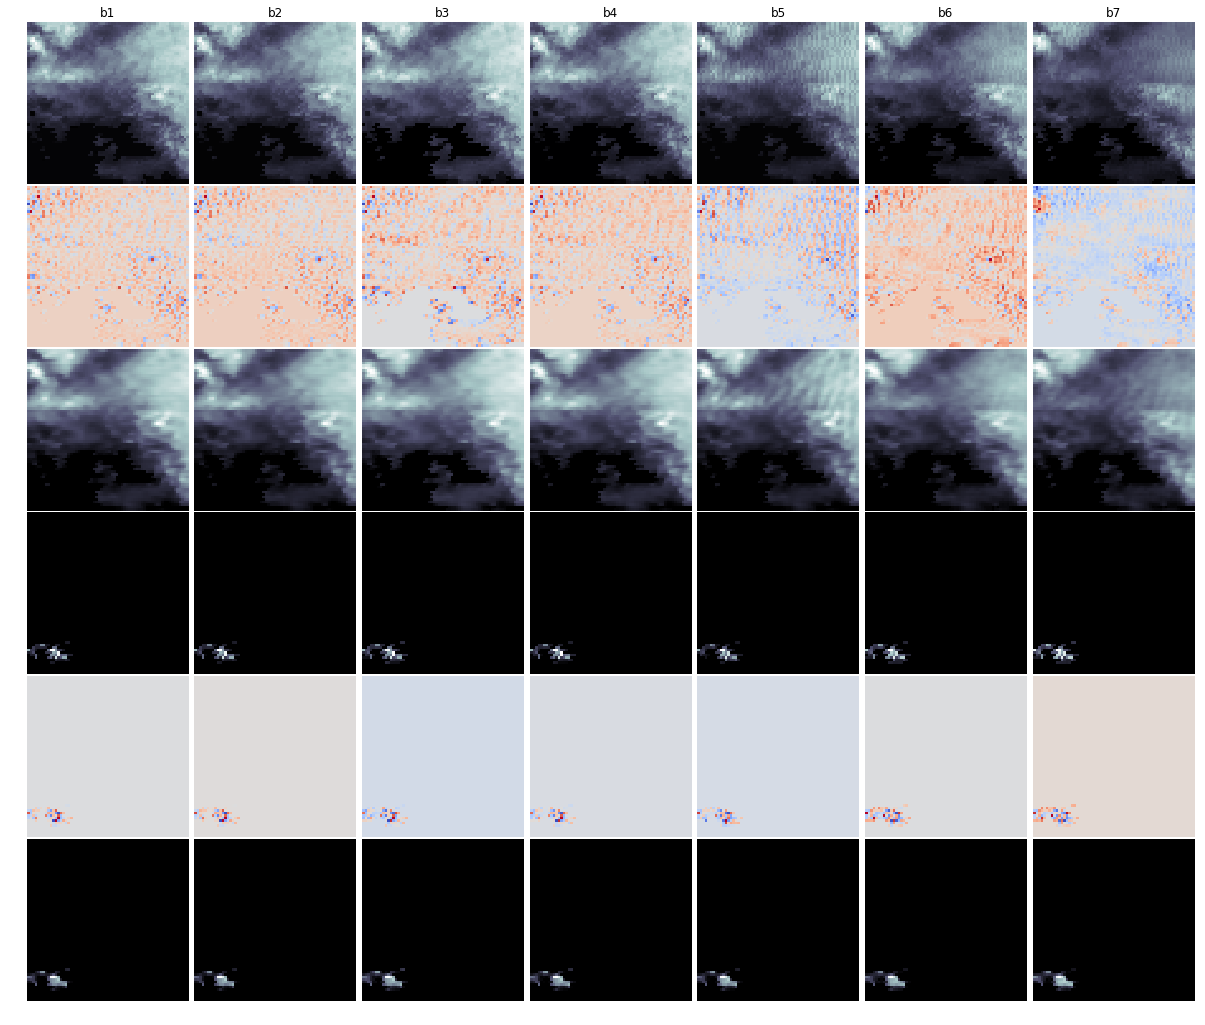

In [50]:
samples = 2
width = 3
fig, ax = plt.subplots(
    nrows=samples * 3,
    ncols=len(fields),
    figsize=(len(fields) * width, samples * width * 3)
)
plt.subplots_adjust(wspace=0.01, hspace=0.01)

for s in range(samples):
    for c, field in enumerate(fields):
        orig = ax[s * 3, c]
        orig.imshow(y[s,:,:, c], cmap="bone")
        if s == 0: orig.set_title(field)
        
        diff = ax[s * 3 + 1, c]
        diff.imshow(y[s,:,:, c] - dec[s, :, :, c], cmap="coolwarm")
            
        out = ax[s * 3 + 2, c]
        out.imshow(dec[s, :, :, c], cmap="bone")
for a in ax.flatten():
    a.set_axis_off()

## PCA Analysis

### Get more data 

In [12]:
n = 3200

ys = []
encodings = []
with tf.Session() as sess:
    for _ in range(n // batch_size):
        ys.append(sess.run(x))
ys_ = []       
for y in ys:
    [enc, _] = ae.predict(y.astype(np.float32))
    spatial_averaged = enc.mean(axis=(1,2))
    encodings.extend(list(spatial_averaged))
    ys_.extend(y)
ys = ys_
    
encodings = np.array(encodings)

### Compute PCA

In [13]:
centered = encodings - encodings.mean(axis=0)
cov = centered.transpose().dot(centered) / centered.shape[0]
evals, evecs = np.linalg.eigh(cov)
evals = np.flip(evals)
evecs = np.flip(evecs, axis=1)

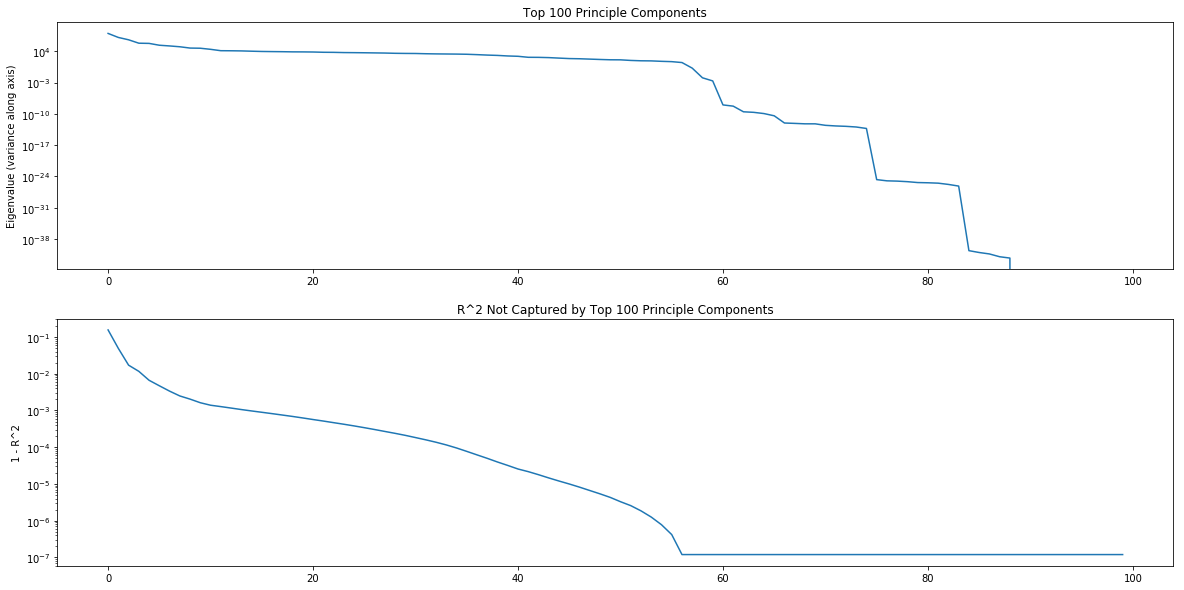

In [14]:
D = 100
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 10))

ax1.plot(evals[:D])
ax1.set_title("Top %d Principle Components"% D)
ax1.set_yscale("log")
ax1.set_ylabel("Eigenvalue (variance along axis)")

ax2.plot(1 - evals.cumsum()[:D] / evals.sum())
ax2.set_title("R^2 Not Captured by Top %d Principle Components"%D)
ax2.set_yscale("log")
ax2.set_ylabel("1 - R^2");

### PCA Projection

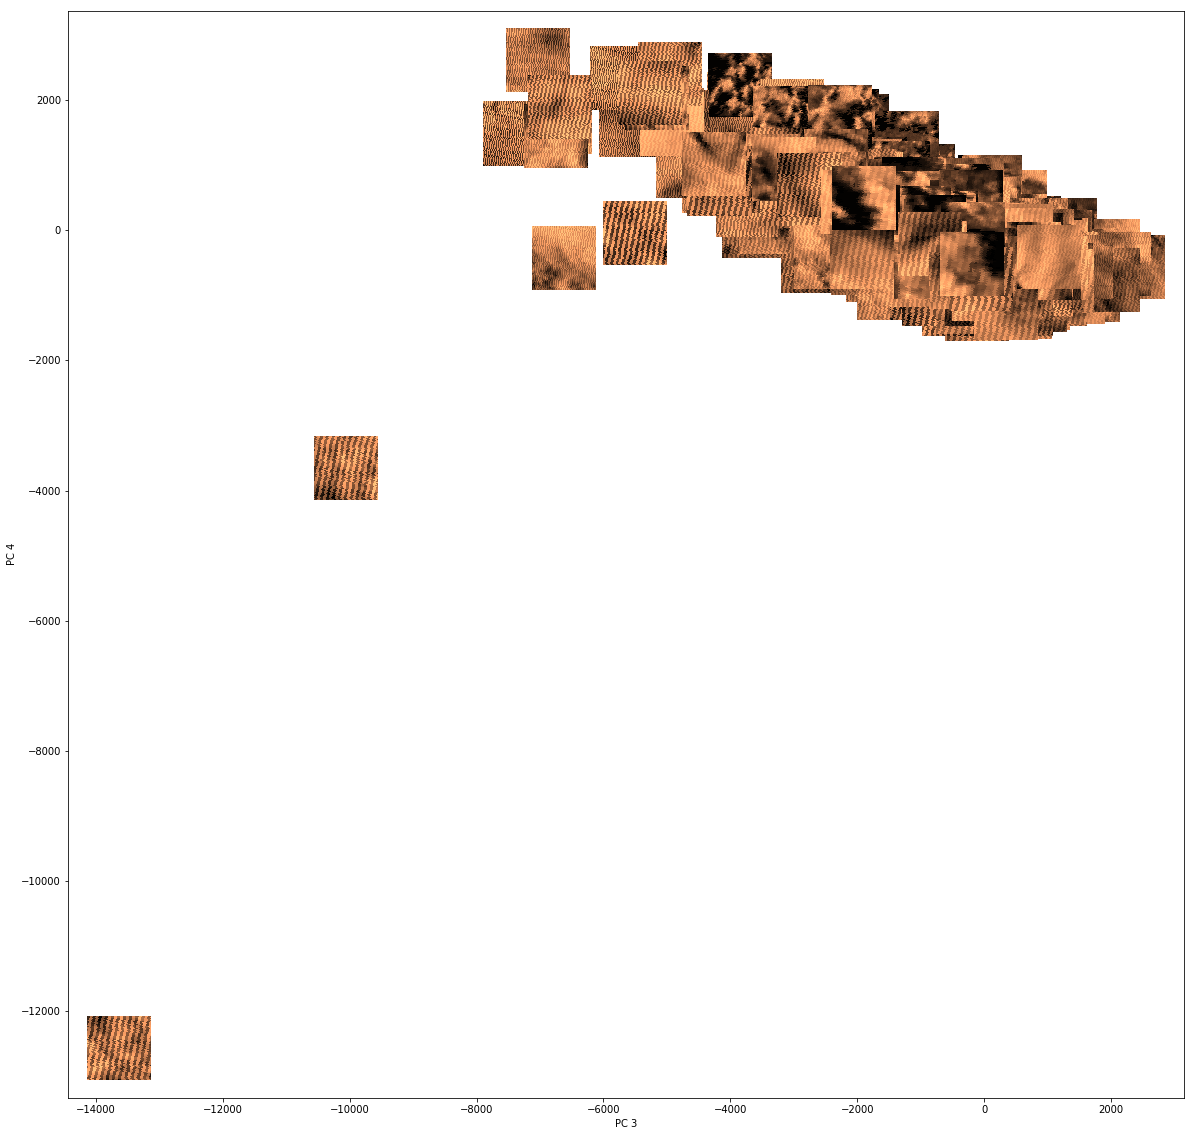

In [58]:
N = 500
# This is zero indexed
dimensions = [2, 3]

projected = centered.dot(evecs[:, dimensions])
fig, ax = img_scatter(
    projected[:N], 
    [y[:,:,4] for y in ys[:N]],
    zoom=1.0
)
ax.set_xlabel("PC %d"%dimensions[0])
ax.set_ylabel("PC %d"%dimensions[1]);

## T-SNE Projection

In [59]:
N = 500
dims = 50
projected = centered[:N,:].dot(evecs[:, :dims])

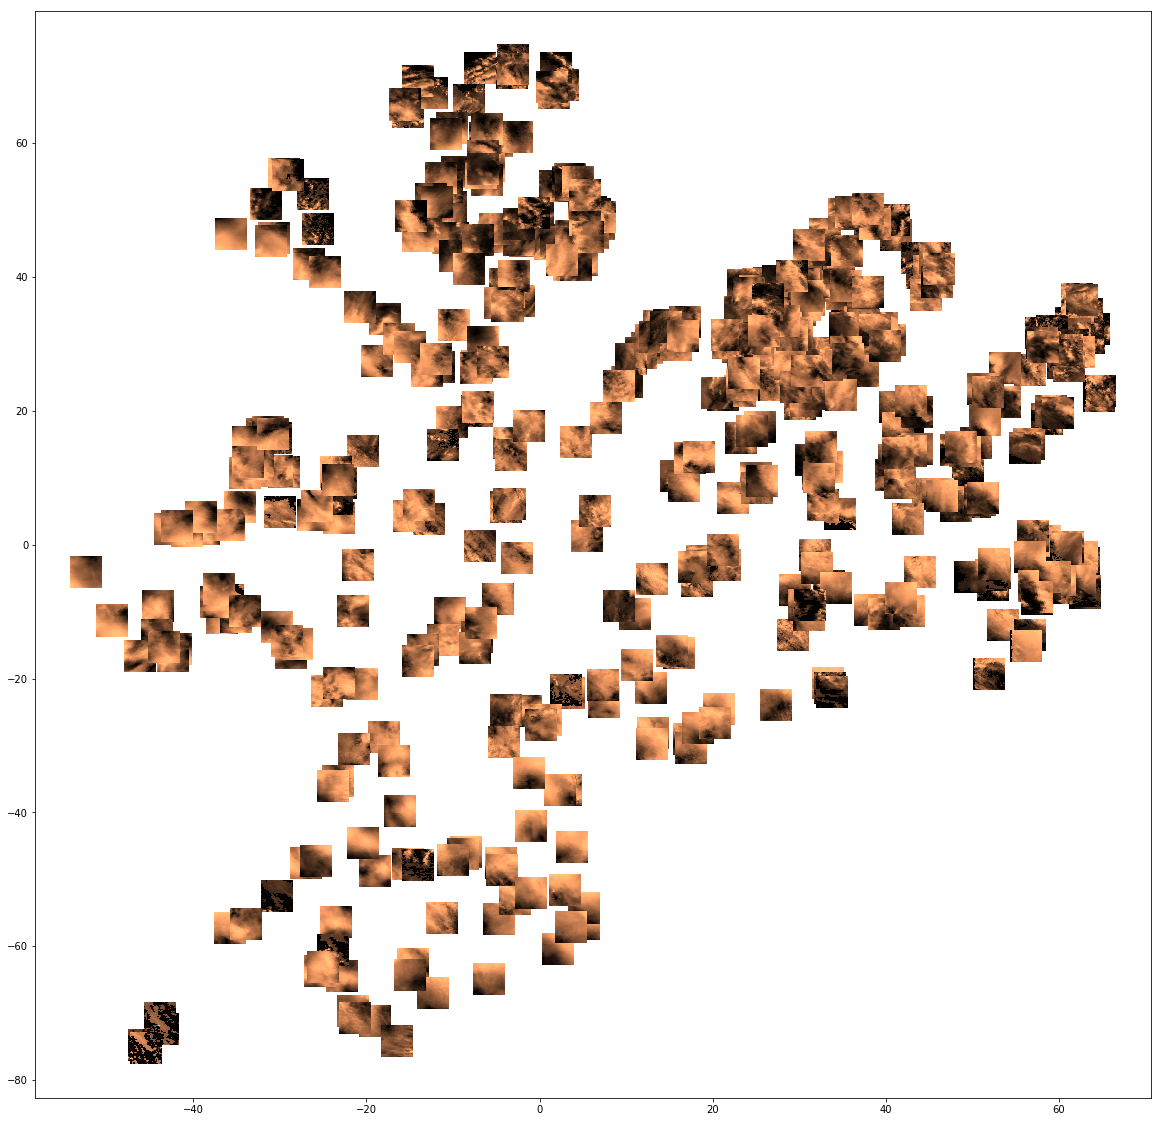

In [59]:
t = TSNE()
embedding = t.fit_transform(projected)
fig, ax = img_scatter(
    embedding,
    [y[:,:,0] for y in ys[:N]],
)